In [34]:
# author: Zhuocheng Sun, Yueyu Wang
# instructor: Tyler Caraza-Harter

from shapely.geometry import Point, Polygon
import shapefile as shp
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import contextily as ctx
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [35]:
df = pd.read_csv("apartments.csv")
pts_col = []
for pt in df[["XCoord", "YCoord"]].itertuples():
    pts_col.append(Point(pt.XCoord, pt.YCoord))
df["geometry"] = pts_col
df = df[["Address", "PropertyUse", "PropertyClass", "Bedrooms", "geometry", "XCoord", "YCoord"]]
df = gpd.GeoDataFrame(df)
df = df.set_crs("esri:103412")
df = df.to_crs(epsg=4326)
df = df[["Address", "PropertyUse", "PropertyClass", "Bedrooms", "geometry", "XCoord", "YCoord"]]
residential = df[df["PropertyClass"] == "Residential"]
residential = residential[residential["PropertyUse"] != "Vacant"]
residential = residential[residential["PropertyUse"] != "Other"]
residential = residential[residential["PropertyUse"] != "Condominium-Notation"]
residential_0_bedroom = residential[residential["Bedrooms"] == 0]

residential_has_bedroom = residential[residential["Bedrooms"] != 0]
average_bedroom = residential_has_bedroom[["PropertyUse", "Bedrooms"]]
average_bedroom = average_bedroom.groupby("PropertyUse", as_index=False).mean()
average_bedroom["Bedrooms"] = round(average_bedroom["Bedrooms"])
average_bedroom["Bedrooms"] = average_bedroom["Bedrooms"].astype(int)
dict_average = dict(zip(average_bedroom['PropertyUse'],average_bedroom['Bedrooms']))
dict_average["3 To 7 Unit"] = 8
residential_0_bedroom = residential_0_bedroom.dropna()
def change_bedroom_for_0(df2):
    return dict_average[df2["PropertyUse"]]

residential_0_bedroom["Bedrooms"] = residential_0_bedroom.apply(lambda  r:change_bedroom_for_0(r), axis=1)
residential_0_bedroom = residential_0_bedroom[~residential_0_bedroom["Address"].str.contains("CDM")]

residential = pd.concat([residential_has_bedroom, residential_0_bedroom])

commercial = df[df["PropertyClass"] == "Commercial"]
commercial['Apartment'] = commercial['PropertyUse'].str.contains("Apartment")
commercial = commercial[commercial["Apartment"] == True]
commercial = commercial.drop(columns= ["Apartment"])
commercial_unit = commercial[commercial["PropertyUse"].str.contains("unit")]

def change_bedroom(df):
    return int(df["PropertyUse"][:-15]) * 2
commercial_unit['Bedrooms']=commercial_unit.apply(lambda r:change_bedroom(r),axis=1)
commercial_others = commercial[~commercial["PropertyUse"].str.contains("unit")]

def change_bedroom_for_other_commercial(df):
    if df["PropertyUse"] == "Apartment & office":
        return 3*2
    if df["PropertyUse"] == "Apartment & store":
        return 2*2
    if df["PropertyUse"] == "Apartments":
        return 5*2
    if df["PropertyUse"] == "Apartments & rooms":
        return 6*2

commercial_others["Bedrooms"] = commercial_others.apply(lambda  r:change_bedroom_for_other_commercial(r), axis=1)

frames = [commercial_unit, commercial_others]
commercial = pd.concat(frames)

frames = [commercial, residential]
df = pd.concat(frames)
df.head()

/opt/anaconda3/envs/CS_HW/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (42,43,104,109,122) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/opt/anaconda3/envs/CS_HW/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,Address,PropertyUse,PropertyClass,Bedrooms,geometry,XCoord,YCoord
22,2218 Allied Dr,8 unit Apartment,Commercial,16,POINT (-89.45969 43.02980),800982.301653,466465.530860
23,2218 Rosenberry Rd,8 unit Apartment,Commercial,16,POINT (-89.45839 43.02956),801330.016423,466379.037780
332,2334 Talc Trl,40 unit Apartment,Commercial,80,POINT (-89.53268 43.02574),781462.275894,465004.129355
510,813 N Thompson Dr,40 unit Apartment,Commercial,80,POINT (-89.29742 43.10858),844330.736065,495204.481640
511,910 Rockefeller Ln,8 unit Apartment,Commercial,16,POINT (-89.29836 43.11047),844078.478226,495893.013690


### Generally, 18 year-olds could be either 12th-grade students or college freshmen. Since we found many data entries with majorities of 18-19 year-olds, and many of those properties are located near UW campus, we think it makes more sense to regard them as college students rather than 12th-grade students. Thus, for simplicity, we only count 5 to 17 year-olds as K-12 student in this notebook.

In [41]:
census_df = pd.read_csv("census_by_block_2010/sex_age.csv")
census_df["GEO_ID"] = census_df["GEO_ID"]
census_df = census_df[["GEO_ID", "NAME", "P012001", "P012004", "P012005", "P012006", "P012028", "P012029", "P012030"]]
census_df = census_df.rename(columns = {"NAME":"Area", "P012001": "Total_people", "P012004": "5-9yrMale", "P012005": "10-14yrMale", "P012006": "15-17yrMale", "P012028": "5-9yrFemale", "P012029": "10-14yrFemale", "P012030": "15-17yrFemale"}, inplace=False)
census_df = census_df[1:]
census_df["Total_people"] = census_df["Total_people"].astype(int)
census_df["5-9yr"] = census_df["5-9yrMale"].astype(int) + census_df["5-9yrFemale"].astype(int)
census_df["10-14yr"] = census_df["10-14yrMale"].astype(int) + census_df["10-14yrFemale"].astype(int)
census_df["15-17yr"] = census_df["15-17yrMale"].astype(int) + census_df["15-17yrFemale"].astype(int)
census_df["Total_K-12_block"] = census_df["5-9yr"] + census_df["10-14yr"] + census_df["15-17yr"]
census_df = census_df[census_df["Total_K-12_block"] != 0]
census_df.head()

,GEO_ID,Area,Total_people,5-9yrMale,10-14yrMale,15-17yrMale,5-9yrFemale,10-14yrFemale,15-17yrFemale,5-9yr,10-14yr,15-17yr,Total_K-12_block
1,1000000US550250001001000,"Block 1000, Block Group 1, Census Tract 1, Dan...",170,1,3,1,1,7,4,2,10,5,17
2,1000000US550250001001001,"Block 1001, Block Group 1, Census Tract 1, Dan...",23,1,0,2,0,0,1,1,0,3,4
4,1000000US550250001001003,"Block 1003, Block Group 1, Census Tract 1, Dan...",38,1,1,0,0,1,3,1,2,3,6
5,1000000US550250001001004,"Block 1004, Block Group 1, Census Tract 1, Dan...",141,4,7,4,6,4,3,10,11,7,28
7,1000000US550250001001006,"Block 1006, Block Group 1, Census Tract 1, Dan...",38,1,0,3,0,6,0,1,6,3,10


In [42]:
# spatial join - take dataset A + dataset B = dataset AB, based on space/geographic relationship
# two datasets must have a matched CRS: coordinate reference system

dane = gpd.read_file("newdane/newdane.shp")

dane["GEO_ID"] = "1000000US" + dane["GEOID10"]
dane.head()

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10,NAME10,MTFCC10,UR10,UACE10,UATYP10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry,GEO_ID
0,55,025,000504,4022,550250005044022,Block 4022,G5040,U,53200,U,S,29724,0,+43.0201083,-089.5332753,"POLYGON ((-89.53341 43.02386, -89.53338 43.024...",1000000US550250005044022
1,55,025,011402,2035,550250114022035,Block 2035,G5040,U,53200,U,S,966914,0,+43.1459496,-089.2952544,"POLYGON ((-89.30400 43.15012, -89.29644 43.148...",1000000US550250114022035
2,55,025,011402,2055,550250114022055,Block 2055,G5040,U,53200,U,S,424,0,+43.1371818,-089.2960596,"POLYGON ((-89.29621 43.13719, -89.29602 43.137...",1000000US550250114022055
3,55,025,011401,3028,550250114013028,Block 3028,G5040,U,53200,U,S,27367,0,+43.0793222,-089.2820008,"POLYGON ((-89.28349 43.08452, -89.28278 43.082...",1000000US550250114013028
4,55,025,010901,1102,550250109011102,Block 1102,G5040,U,53200,U,S,23669,0,+43.0739416,-089.5306223,"POLYGON ((-89.53099 43.07488, -89.52984 43.074...",1000000US550250109011102


In [43]:
dane.to_crs(df.crs, inplace=True)
dane['area'] = dane.to_crs(epsg=3857).area/2.59e+06
block_with_apartment = gpd.sjoin(df, dane, how="left", op="within")
block_with_apartment = block_with_apartment[['Address', 'PropertyUse', 'PropertyClass', 'Bedrooms','geometry', "XCoord", "YCoord",  'GEO_ID', 'area']]
block_with_apartment.head()

,Address,PropertyUse,PropertyClass,Bedrooms,geometry,XCoord,YCoord,GEO_ID,area
22,2218 Allied Dr,8 unit Apartment,Commercial,16,POINT (-89.45969 43.02980),800982.301653,466465.530860,1000000US550250006002000,0.039495
23,2218 Rosenberry Rd,8 unit Apartment,Commercial,16,POINT (-89.45839 43.02956),801330.016423,466379.037780,1000000US550250006002001,0.016105
332,2334 Talc Trl,40 unit Apartment,Commercial,80,POINT (-89.53268 43.02574),781462.275894,465004.129355,1000000US550250005044020,0.020012
510,813 N Thompson Dr,40 unit Apartment,Commercial,80,POINT (-89.29742 43.10858),844330.736065,495204.481640,1000000US550250026032068,0.009523
511,910 Rockefeller Ln,8 unit Apartment,Commercial,16,POINT (-89.29836 43.11047),844078.478226,495893.013690,1000000US550250026032059,0.017940


In [44]:
merged = pd.merge(block_with_apartment, census_df, on="GEO_ID", how='inner')
merged = merged[["Area","Address", "PropertyUse", "PropertyClass", "Bedrooms", "geometry", "XCoord", "YCoord", "Total_people", "Total_K-12_block", "GEO_ID", "area"]]
merged['BlockBedrooms'] = merged.groupby(['GEO_ID']).Bedrooms.transform('sum')
merged.head()

,Area,Address,PropertyUse,PropertyClass,Bedrooms,geometry,XCoord,YCoord,Total_people,Total_K-12_block,GEO_ID,area,BlockBedrooms
0,"Block 2000, Block Group 2, Census Tract 6, Dan...",2218 Allied Dr,8 unit Apartment,Commercial,16,POINT (-89.45969 43.02980),800982.301653,466465.530860,294,87,1000000US550250006002000,0.039495,258
1,"Block 2000, Block Group 2, Census Tract 6, Dan...",2322 Allied Dr,8 unit Apartment,Commercial,16,POINT (-89.45995 43.02816),800912.471326,465869.120662,294,87,1000000US550250006002000,0.039495,258
2,"Block 2000, Block Group 2, Census Tract 6, Dan...",2306 Allied Dr,8 unit Apartment,Commercial,16,POINT (-89.45986 43.02871),800935.774665,466068.197512,294,87,1000000US550250006002000,0.039495,258
3,"Block 2000, Block Group 2, Census Tract 6, Dan...",2226 Allied Dr,8 unit Apartment,Commercial,16,POINT (-89.45973 43.02952),800970.644487,466366.051694,294,87,1000000US550250006002000,0.039495,258
4,"Block 2000, Block Group 2, Census Tract 6, Dan...",2234 Allied Dr,8 unit Apartment,Commercial,16,POINT (-89.45978 43.02925),800959.021351,466267.246640,294,87,1000000US550250006002000,0.039495,258


In [45]:
merged["K12_est"] = merged["Total_K-12_block"] * merged["Bedrooms"] / merged["BlockBedrooms"]
K12_df = merged
K12_df.head()

,Area,Address,PropertyUse,PropertyClass,Bedrooms,geometry,XCoord,YCoord,Total_people,Total_K-12_block,GEO_ID,area,BlockBedrooms,K12_est
0,"Block 2000, Block Group 2, Census Tract 6, Dan...",2218 Allied Dr,8 unit Apartment,Commercial,16,POINT (-89.45969 43.02980),800982.301653,466465.530860,294,87,1000000US550250006002000,0.039495,258,5.395349
1,"Block 2000, Block Group 2, Census Tract 6, Dan...",2322 Allied Dr,8 unit Apartment,Commercial,16,POINT (-89.45995 43.02816),800912.471326,465869.120662,294,87,1000000US550250006002000,0.039495,258,5.395349
2,"Block 2000, Block Group 2, Census Tract 6, Dan...",2306 Allied Dr,8 unit Apartment,Commercial,16,POINT (-89.45986 43.02871),800935.774665,466068.197512,294,87,1000000US550250006002000,0.039495,258,5.395349
3,"Block 2000, Block Group 2, Census Tract 6, Dan...",2226 Allied Dr,8 unit Apartment,Commercial,16,POINT (-89.45973 43.02952),800970.644487,466366.051694,294,87,1000000US550250006002000,0.039495,258,5.395349
4,"Block 2000, Block Group 2, Census Tract 6, Dan...",2234 Allied Dr,8 unit Apartment,Commercial,16,POINT (-89.45978 43.02925),800959.021351,466267.246640,294,87,1000000US550250006002000,0.039495,258,5.395349


In [46]:
lake_df = gpd.read_file("lakes.zip")

Text(0.5, 1.0, 'Figure 1: Number of K-12 students in Madison per census block')

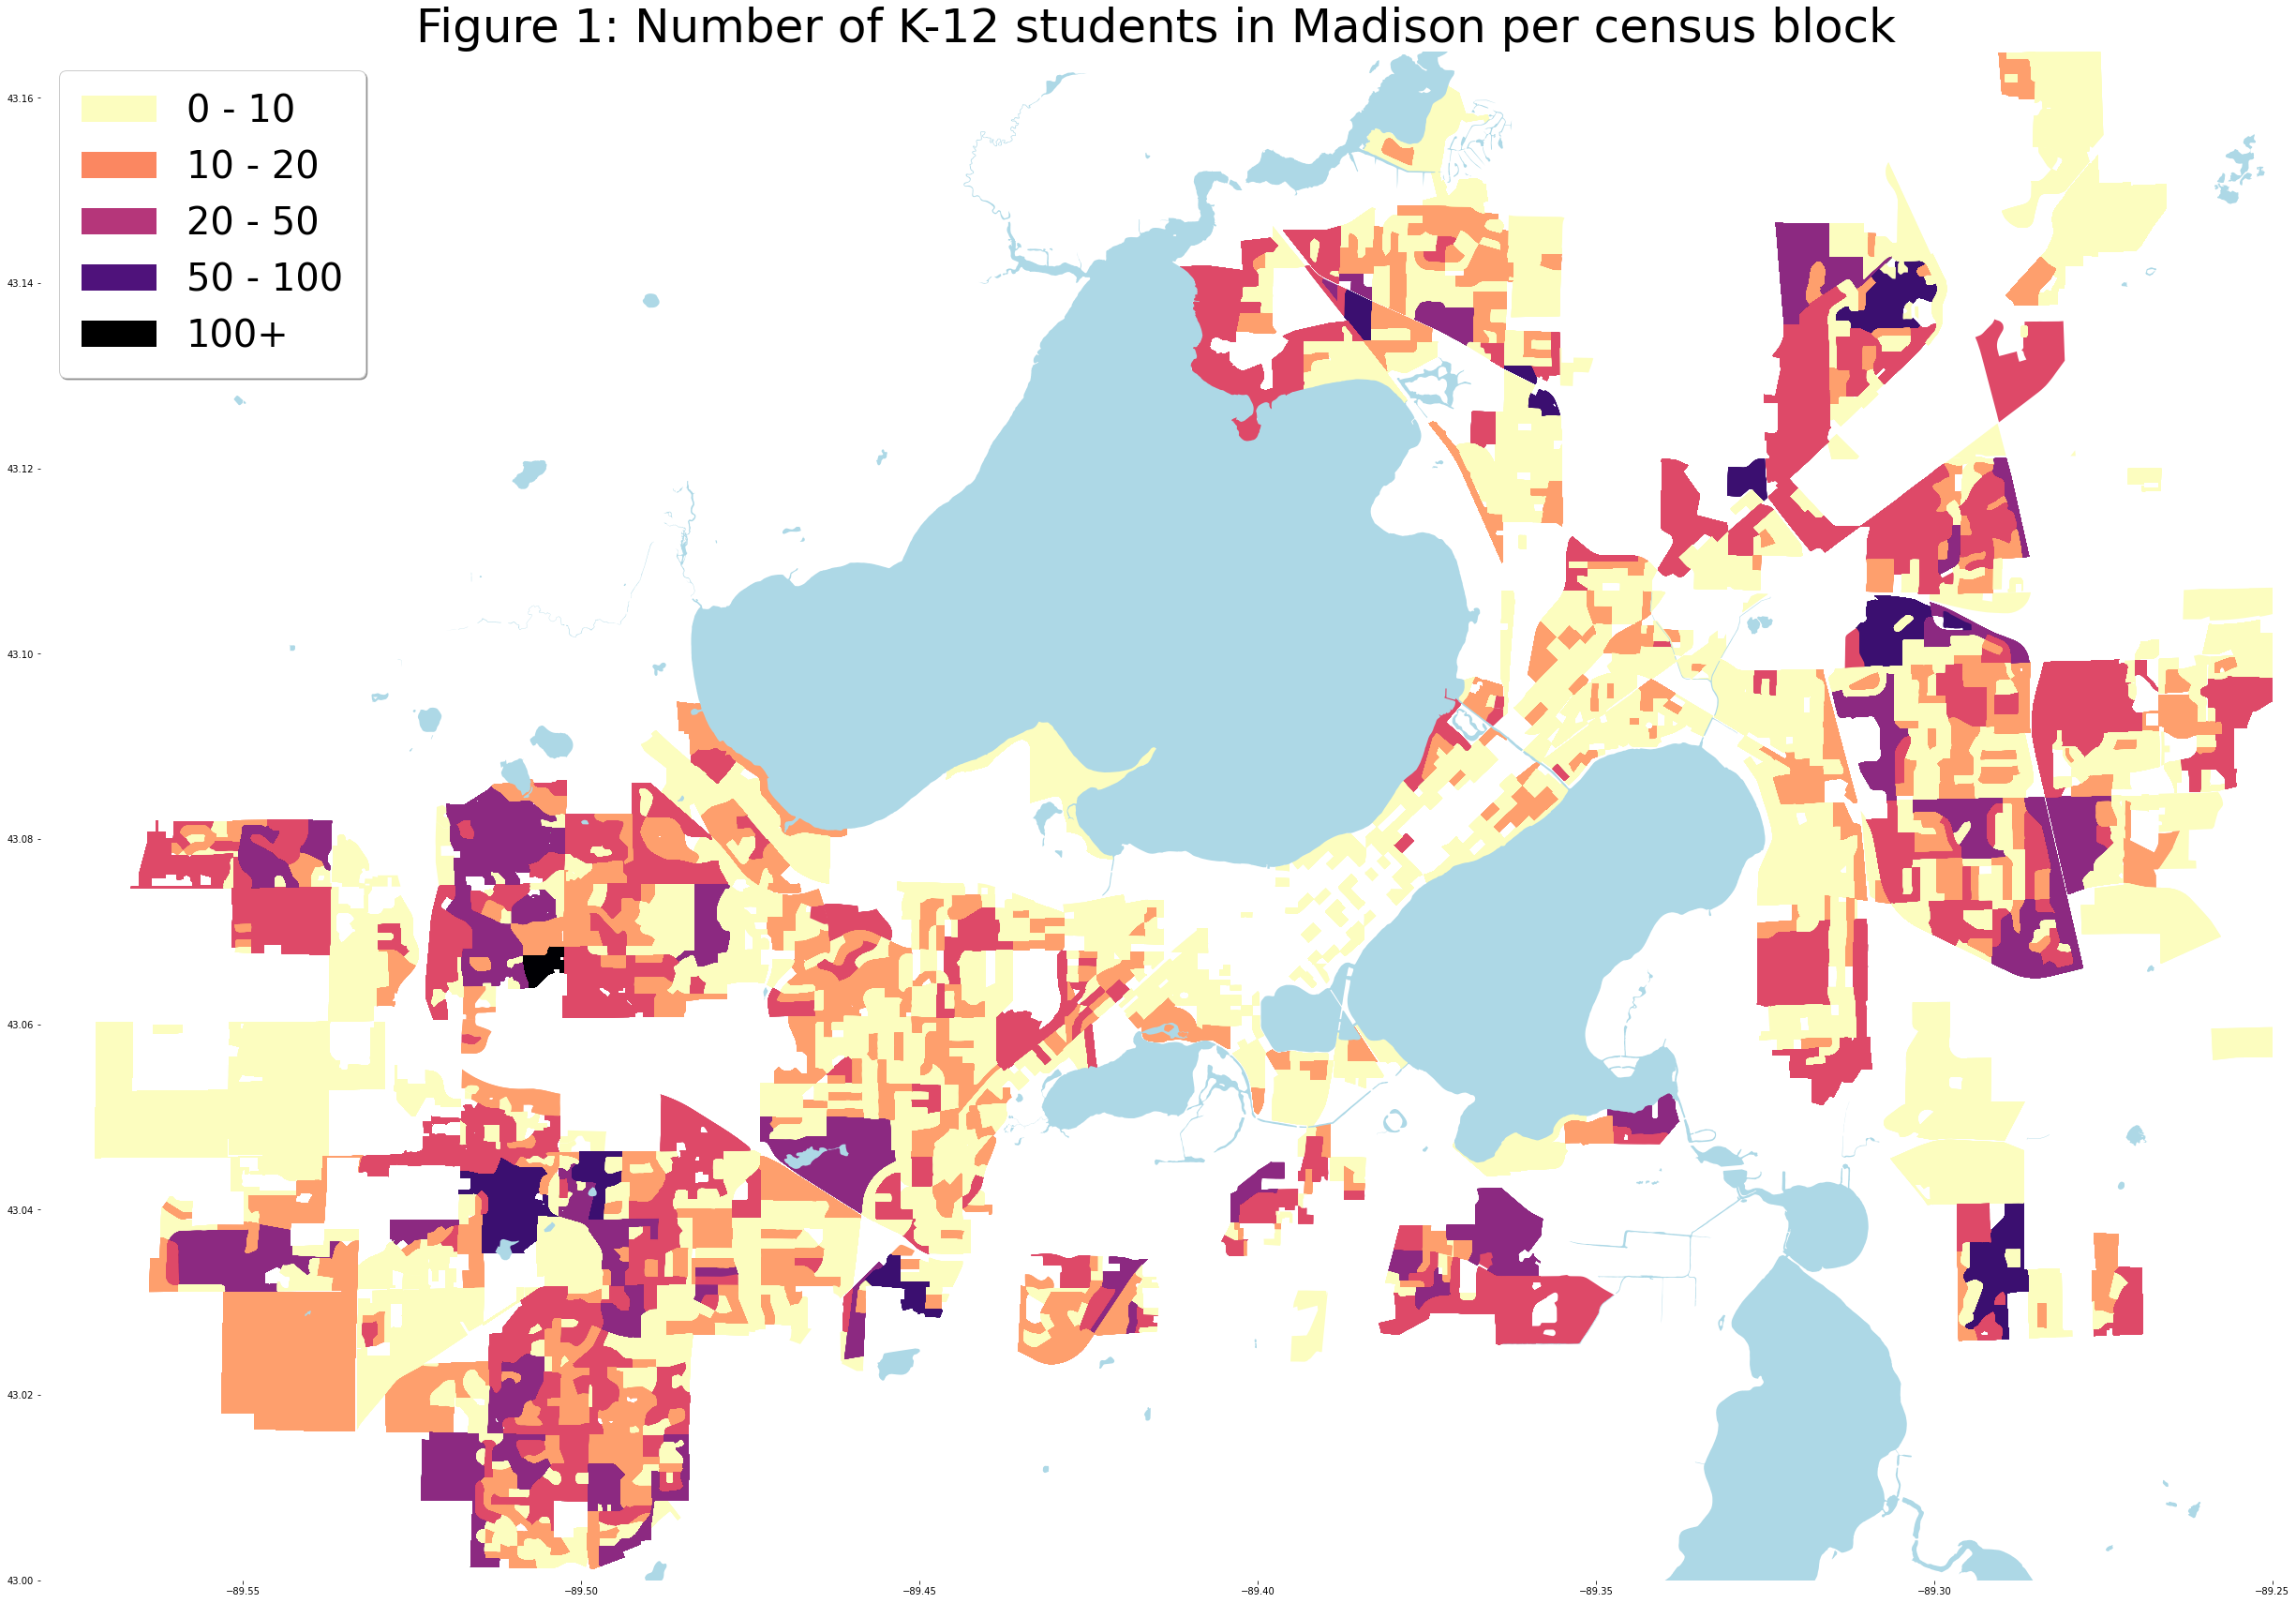

In [47]:
import matplotlib.patches as mpatches
import mapclassify as mc

madison = gpd.sjoin(K12_df, dane, how="right", op="within")
madison = madison[madison["Total_K-12_block"] >= 0]
bp = mc.UserDefined(madison["Total_K-12_block"], bins=[10, 20, 50, 100, 150])
ax = madison.plot(figsize = (50, 30), legend=True, scheme = 'UserDefined',
                  classification_kwds={'bins': [10, 20, 50, 100, 150]},
                  k = 5, column='Total_K-12_block', cmap = 'magma_r')
lake_df.plot(ax=ax,color="lightblue")
handles, labels = ax.get_legend_handles_labels()
cmap = plt.get_cmap('magma_r')
bins = bp.bins
bins = np.insert(bins, 0, 0)
LegendElement = [mpatches.Patch(facecolor=cmap(_*0.25), label=f'{int(max(bins[_], 0))} - {int(bins[_+1])}')
                 for _ in range(4)] + [mpatches.Patch(facecolor='black', hatch='', label='100+')]
ax.legend(handles = LegendElement, loc='upper left', fontsize=40, shadow=True, borderpad=0.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim([43.000, 43.165])
ax.set_xlim([-89.58, -89.25])
# ax.axis('off')
ax.set_title("Figure 1: Number of K-12 students in Madison per census block", fontsize = 50)

## Linear Regression part

In [50]:
Condominium_bedroom_block = merged
Condominium_bedroom_block = Condominium_bedroom_block[Condominium_bedroom_block["PropertyUse"] != "2 Unit"]
Condominium_bedroom_block = Condominium_bedroom_block[Condominium_bedroom_block["PropertyUse"] != "Single family"]
Condominium_bedroom_block = Condominium_bedroom_block[Condominium_bedroom_block["PropertyUse"] != "3 To 7 Unit"]
Condominium_bedroom_block = Condominium_bedroom_block[["Area", "Address", "PropertyUse", "Bedrooms", "Total_K-12_block", "GEO_ID", "BlockBedrooms", "geometry", "area"]]
Condominium_bedroom_block["Apartment_bedroom"] = Condominium_bedroom_block.groupby(['GEO_ID']).Bedrooms.transform('sum')
Condominium_bedroom_block["House_bedroom"] = Condominium_bedroom_block["BlockBedrooms"] - Condominium_bedroom_block["Apartment_bedroom"]
Condominium_bedroom_block = Condominium_bedroom_block.drop_duplicates("GEO_ID")
Condominium_bedroom_block = Condominium_bedroom_block[["GEO_ID", "Apartment_bedroom", "House_bedroom"]]
total_bedroom_block = merged[["GEO_ID", "BlockBedrooms", "Total_K-12_block", "geometry", "area"]]
total_bedroom_block = total_bedroom_block.drop_duplicates("GEO_ID")
result = total_bedroom_block.merge(Condominium_bedroom_block, on="GEO_ID", how = "outer")
result["Apartment_bedroom"].fillna(0, inplace=True)
result["House_bedroom"].fillna(result["BlockBedrooms"], inplace=True)
result

,GEO_ID,BlockBedrooms,Total_K-12_block,geometry,area,Apartment_bedroom,House_bedroom
0,1000000US550250006002000,258,87,POINT (-89.45969 43.02980),0.039495,258.0,0.0
1,1000000US550250006002001,156,14,POINT (-89.45839 43.02956),0.016105,156.0,0.0
2,1000000US550250005044020,140,9,POINT (-89.53268 43.02574),0.020012,88.0,52.0
3,1000000US550250026032068,204,32,POINT (-89.29742 43.10858),0.009523,204.0,0.0
4,1000000US550250026032059,132,19,POINT (-89.29836 43.11047),0.017940,132.0,0.0
...,...,...,...,...,...,...,...
2281,1000000US550250114011030,50,1,POINT (-89.26252 43.09823),0.024686,50.0,0.0
2282,1000000US550250108005023,168,1,POINT (-89.50401 43.01107),0.018807,168.0,0.0
2283,1000000US550250108005038,82,3,POINT (-89.49956 43.00429),0.006566,82.0,0.0
2284,1000000US550250004053006,1086,5,POINT (-89.50790 43.04905),0.013436,1086.0,0.0


4.383149098503588


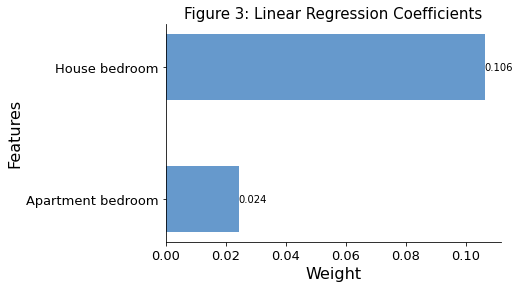

In [49]:
xcol = ["Apartment_bedroom", "House_bedroom"]
model1 = Pipeline([
            ("lr", LinearRegression())
        ])
model1.fit(result[xcol], result["Total_K-12_block"])

idx = [t.replace("_", " ") for t in xcol]
fig, ax = plt.subplots()
ax3 = ax.barh(range(len(idx)), model1["lr"].coef_, color='#6699CC', height = 0.5 )
ax.tick_params(labelsize=13)
for rect in ax3:
    w = rect.get_width()
    ax.text(w, rect.get_y()+rect.get_height()/2,
            "%.3f" % w, ha='left', va='center')
ax.set_yticks(range(len(idx)))
ax.set_yticklabels(idx)
ax.set_xlabel("Weight", fontsize=16)
ax.set_ylabel("Features", fontsize=16)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("Figure 3: Linear Regression Coefficients", fontsize=15)
print(model1["lr"].coef_[1] / model1["lr"].coef_[0])

In [54]:
# adjust the k-12 estimation using the new model
total = model1["lr"].coef_[0] + model1["lr"].coef_[1]
apt_pro = model1["lr"].coef_[0]
house_pro = model1["lr"].coef_[1]
ratio = model1["lr"].coef_[1] / model1["lr"].coef_[0]
result["BlockTotal_for_calculate"] = result["Apartment_bedroom"] + ratio * result["House_bedroom"]
estimator = result[["GEO_ID", "BlockTotal_for_calculate"]]
estimator_dict = dict(zip(estimator['GEO_ID'],estimator['BlockTotal_for_calculate']))
def estimate_K12(df):
    if df["PropertyUse"] not in ["2 Unit", "Single family", "3 To 7 Unit"]:
        return df["Total_K-12_block"] * df["Bedrooms"]/ estimator_dict[df["GEO_ID"]]
    if df["PropertyUse"] in ["2 Unit", "Single family", "3 To 7 Unit"]:
        return df["Total_K-12_block"] * df["Bedrooms"]/ estimator_dict[df["GEO_ID"]] * ratio


K12_df["K12_est"] = K12_df.apply(lambda  r:estimate_K12(r), axis=1)
K12_df

,Area,Address,PropertyUse,PropertyClass,Bedrooms,geometry,XCoord,YCoord,Total_people,Total_K-12_block,GEO_ID,area,BlockBedrooms,K12_est
0,"Block 2000, Block Group 2, Census Tract 6, Dan...",2218 Allied Dr,8 unit Apartment,Commercial,16,POINT (-89.45969 43.02980),800982.301653,466465.530860,294,87,1000000US550250006002000,0.039495,258,5.395349
1,"Block 2000, Block Group 2, Census Tract 6, Dan...",2322 Allied Dr,8 unit Apartment,Commercial,16,POINT (-89.45995 43.02816),800912.471326,465869.120662,294,87,1000000US550250006002000,0.039495,258,5.395349
2,"Block 2000, Block Group 2, Census Tract 6, Dan...",2306 Allied Dr,8 unit Apartment,Commercial,16,POINT (-89.45986 43.02871),800935.774665,466068.197512,294,87,1000000US550250006002000,0.039495,258,5.395349
3,"Block 2000, Block Group 2, Census Tract 6, Dan...",2226 Allied Dr,8 unit Apartment,Commercial,16,POINT (-89.45973 43.02952),800970.644487,466366.051694,294,87,1000000US550250006002000,0.039495,258,5.395349
4,"Block 2000, Block Group 2, Census Tract 6, Dan...",2234 Allied Dr,8 unit Apartment,Commercial,16,POINT (-89.45978 43.02925),800959.021351,466267.246640,294,87,1000000US550250006002000,0.039495,258,5.395349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64317,"Block 3006, Block Group 3, Census Tract 4.05, ...",701 Harbor House Dr Unit P25,Condominium,Residential,2,POINT (-89.50790 43.04905),788099.224258,473494.448717,84,5,1000000US550250004053006,0.013436,1086,0.009208
64318,"Block 3006, Block Group 3, Census Tract 4.05, ...",701 Harbor House Dr Unit P26,Condominium,Residential,2,POINT (-89.50790 43.04905),788099.224258,473494.448717,84,5,1000000US550250004053006,0.013436,1086,0.009208
64319,"Block 3006, Block Group 3, Census Tract 4.05, ...",701 Harbor House Dr Unit P27,Condominium,Residential,2,POINT (-89.50790 43.04905),788099.224258,473494.448717,84,5,1000000US550250004053006,0.013436,1086,0.009208
64320,"Block 3006, Block Group 3, Census Tract 4.05, ...",701 Harbor House Dr Unit P28,Condominium,Residential,2,POINT (-89.50790 43.04905),788099.224258,473494.448717,84,5,1000000US550250004053006,0.013436,1086,0.009208


## Top 70 apartments table

In [55]:
# sort by the number of K-12 children estimation grouped by Point.
K12_df["K-12_by_point"] = K12_df.groupby(by=["XCoord", "YCoord"])["K12_est"].transform('sum')
point_order = K12_df.sort_values(by=['K-12_by_point'], ascending=False)

In [56]:
Top_70 = K12_df
Top_70 = Top_70[Top_70["PropertyUse"] != "2 Unit"]
Top_70 = Top_70[Top_70["PropertyUse"] != "Single family"]
Top_70 = Top_70[Top_70["PropertyUse"] != "3 To 7 Unit"]
Top_70["Apartment_bedrooms"] = Top_70.groupby(["XCoord", "YCoord"]).Bedrooms.transform(sum)
Top_70 = Top_70.drop_duplicates("geometry")
Top_70 = Top_70.sort_values(by=['K-12_by_point'], ascending=False)
Top_70 = Top_70[:70]
Top_70 = Top_70[["Area", "Address", "geometry", "Apartment_bedrooms", "K-12_by_point", "XCoord", "YCoord", "GEO_ID"]]
total_70 = Top_70[["Address", "Apartment_bedrooms", "K-12_by_point"]]
total_70.to_csv("Top70_Apartments.csv", index = False)
Top_70.head()

,Area,Address,geometry,Apartment_bedrooms,K-12_by_point,XCoord,YCoord,GEO_ID
7828,"Block 1004, Block Group 1, Census Tract 30.02,...",225 N Thompson Dr,POINT (-89.29757 43.10355),632,109.000000,844293.539515,493372.553703,1000000US550250030021004
134,"Block 1000, Block Group 1, Census Tract 22, Da...",2002 Elka Ln,POINT (-89.35622 43.12655),144,63.614067,828623.001168,501737.020054,1000000US550250022001000
4559,"Block 1008, Block Group 1, Census Tract 23.01,...",501 Northport Dr,POINT (-89.38920 43.13941),256,58.000000,819817.493817,506417.236236,1000000US550250023011008
7979,"Block 1009, Block Group 1, Census Tract 23.01,...",57 Northridge Ter,POINT (-89.38715 43.13717),96,51.121890,820364.949154,505601.723288,1000000US550250023011009
57647,"Block 2013, Block Group 2, Census Tract 24.02,...",312 East Bluff,POINT (-89.36489 43.13251),441,44.464498,826307.976245,503907.104675,1000000US550250024022013


In [57]:
Top_70 = Top_70.reset_index()
Top_70 = Top_70[["Address", "GEO_ID", "Apartment_bedrooms", "K-12_by_point", "geometry"]]

In [58]:
Top_70.iloc[47]

Address                                          7502 Westward Way
GEO_ID                                    1000000US550250002043011
Apartment_bedrooms                                              64
K-12_by_point                                                 16.0
geometry              POINT (-89.51345156283065 43.06155116160458)
Name: 47, dtype: object

In [59]:
# pd.set_option('display.max_rows', None)
block_with_apartment[block_with_apartment["GEO_ID"] == "1000000US550250002043007"].head()

,Address,PropertyUse,PropertyClass,Bedrooms,geometry,XCoord,YCoord,GEO_ID,area
4333,7849 E Oakbrook Cir,Single family,Residential,4,POINT (-89.51790 43.06534),785431.480938,479434.766233,1000000US550250002043007,0.023167
4334,7825 E Oakbrook Cir,Single family,Residential,3,POINT (-89.51807 43.06615),785387.772032,479727.698602,1000000US550250002043007,0.023167
16163,7857 E Oakbrook Cir,Single family,Residential,3,POINT (-89.51780 43.06493),785459.149594,479283.302739,1000000US550250002043007,0.023167
25409,7861 E Oakbrook Cir,Single family,Residential,4,POINT (-89.51782 43.06468),785452.534099,479192.836502,1000000US550250002043007,0.023167
33964,7869 E Oakbrook Cir,Single family,Residential,3,POINT (-89.51832 43.06442),785318.851706,479099.431633,1000000US550250002043007,0.023167


## Plots

#### cumulative children live in apartments

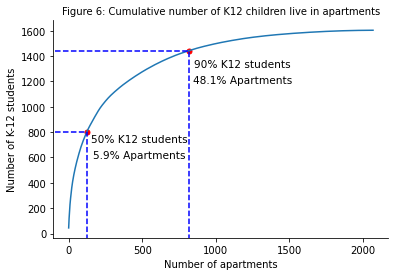

In [84]:
Buildings = K12_df[["GEO_ID", "PropertyUse", "geometry", "Area", "K-12_by_point"]]
Buildings = Buildings[(Buildings["PropertyUse"] == "Condominium") | (Buildings["PropertyUse"] == "2 unit Apartment")
                                   | (Buildings["PropertyUse"] == "3 unit Apartment") | (Buildings["PropertyUse"] == "4 unit Apartment")
                                   | (Buildings["PropertyUse"] == "5 unit Apartment") | (Buildings["PropertyUse"] == "6 unit Apartment")
                                   | (Buildings["PropertyUse"] == "7 unit Apartment")]
Buildings = Buildings.drop_duplicates("geometry")
Buildings = Buildings.sort_values(by=['K-12_by_point'], ascending=False)
K12_data = np.array(Buildings["K-12_by_point"].tolist())
cumulative = pd.DataFrame(K12_data.cumsum())
plt.plot(cumulative)
plt.axis('tight')
plt.title("Figure 6: Cumulative number of K12 children live in apartments", fontsize=10)
plt.xlabel("Number of apartments")
plt.ylabel("Number of K-12 students")
x_50 = 123
y_50 = 801.69
plt.scatter(x_50, y_50, s=25, c='r')
plt.plot([-90, x_50], [y_50, y_50], c='b', linestyle='--')
plt.plot([123, x_50], [-50, y_50], c='b', linestyle='--')
plt.text(x_50+360, y_50-100, '50% K12 students', ha='center', va='bottom', fontsize=10.5)  # horizontal alignment
plt.text(x_50+360, y_50-220, '5.9% Apartments', ha='center', va='bottom', fontsize=10.5)

x_90 = 820
y_90 = 1443.39
plt.scatter(x_90, y_90, s=25, c='r')
plt.plot([-90, x_90], [y_90, y_90], c='b', linestyle='--')
plt.plot([x_90, x_90], [-50, y_90], c='b', linestyle='--')
plt.text(x_90+360, y_90-150, '90% K12 students', ha='center', va='bottom', fontsize=10.5)  # horizontal alignment
plt.text(x_90+360, y_90-270, '39.6% Apartments', ha='center', va='bottom', fontsize=10.5)
ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.show()

In [97]:
cumulative[0].iloc[50]

543.459359379267

## Use the linear regression coef to improve the estimate


In [105]:
total = model1["lr"].coef_[0] + model1["lr"].coef_[1]
apt_pro = model1["lr"].coef_[0]
house_pro = model1["lr"].coef_[1]

result["K12_in_apt"] = result["Total_K-12_block"] / (result["House_bedroom"] + result["Apartment_bedroom"] * (apt_pro/house_pro)) * (result["Apartment_bedroom"] * (apt_pro/house_pro))
result["K12_in_other"] = result["Total_K-12_block"] - result["K12_in_apt"]
result['apt_density'] = result['K12_in_apt'] / result['area']
result['other_density'] = result['K12_in_other'] / result['area']
result.head()

,GEO_ID,BlockBedrooms,Total_K-12_block,geometry,area,Apartment_bedroom,House_bedroom,K12_in_apt,K12_in_other,apt_density,other_density
0,1000000US550250006002000,258,87,POINT (-89.45969 43.02980),0.039495,258.0,0.0,87.000000,0.000000e+00,2202.819568,0.000000e+00
1,1000000US550250006002001,156,14,POINT (-89.45839 43.02956),0.016105,156.0,0.0,14.000000,-1.776357e-15,869.268541,-1.102951e-13
2,1000000US550250005044020,140,9,POINT (-89.53268 43.02574),0.020012,88.0,52.0,2.506934,6.493066e+00,125.271428,3.244583e+02
3,1000000US550250026032068,204,32,POINT (-89.29742 43.10858),0.009523,204.0,0.0,32.000000,0.000000e+00,3360.385726,0.000000e+00
4,1000000US550250026032059,132,19,POINT (-89.29836 43.11047),0.017940,132.0,0.0,19.000000,0.000000e+00,1059.111662,0.000000e+00


In [106]:
lake_df = gpd.read_file("lakes.zip")

### The density plot of k12 in apartment

Text(0.5, 1.0, 'Figure 5: Number of K-12 students living in apartments per square mile in each block')

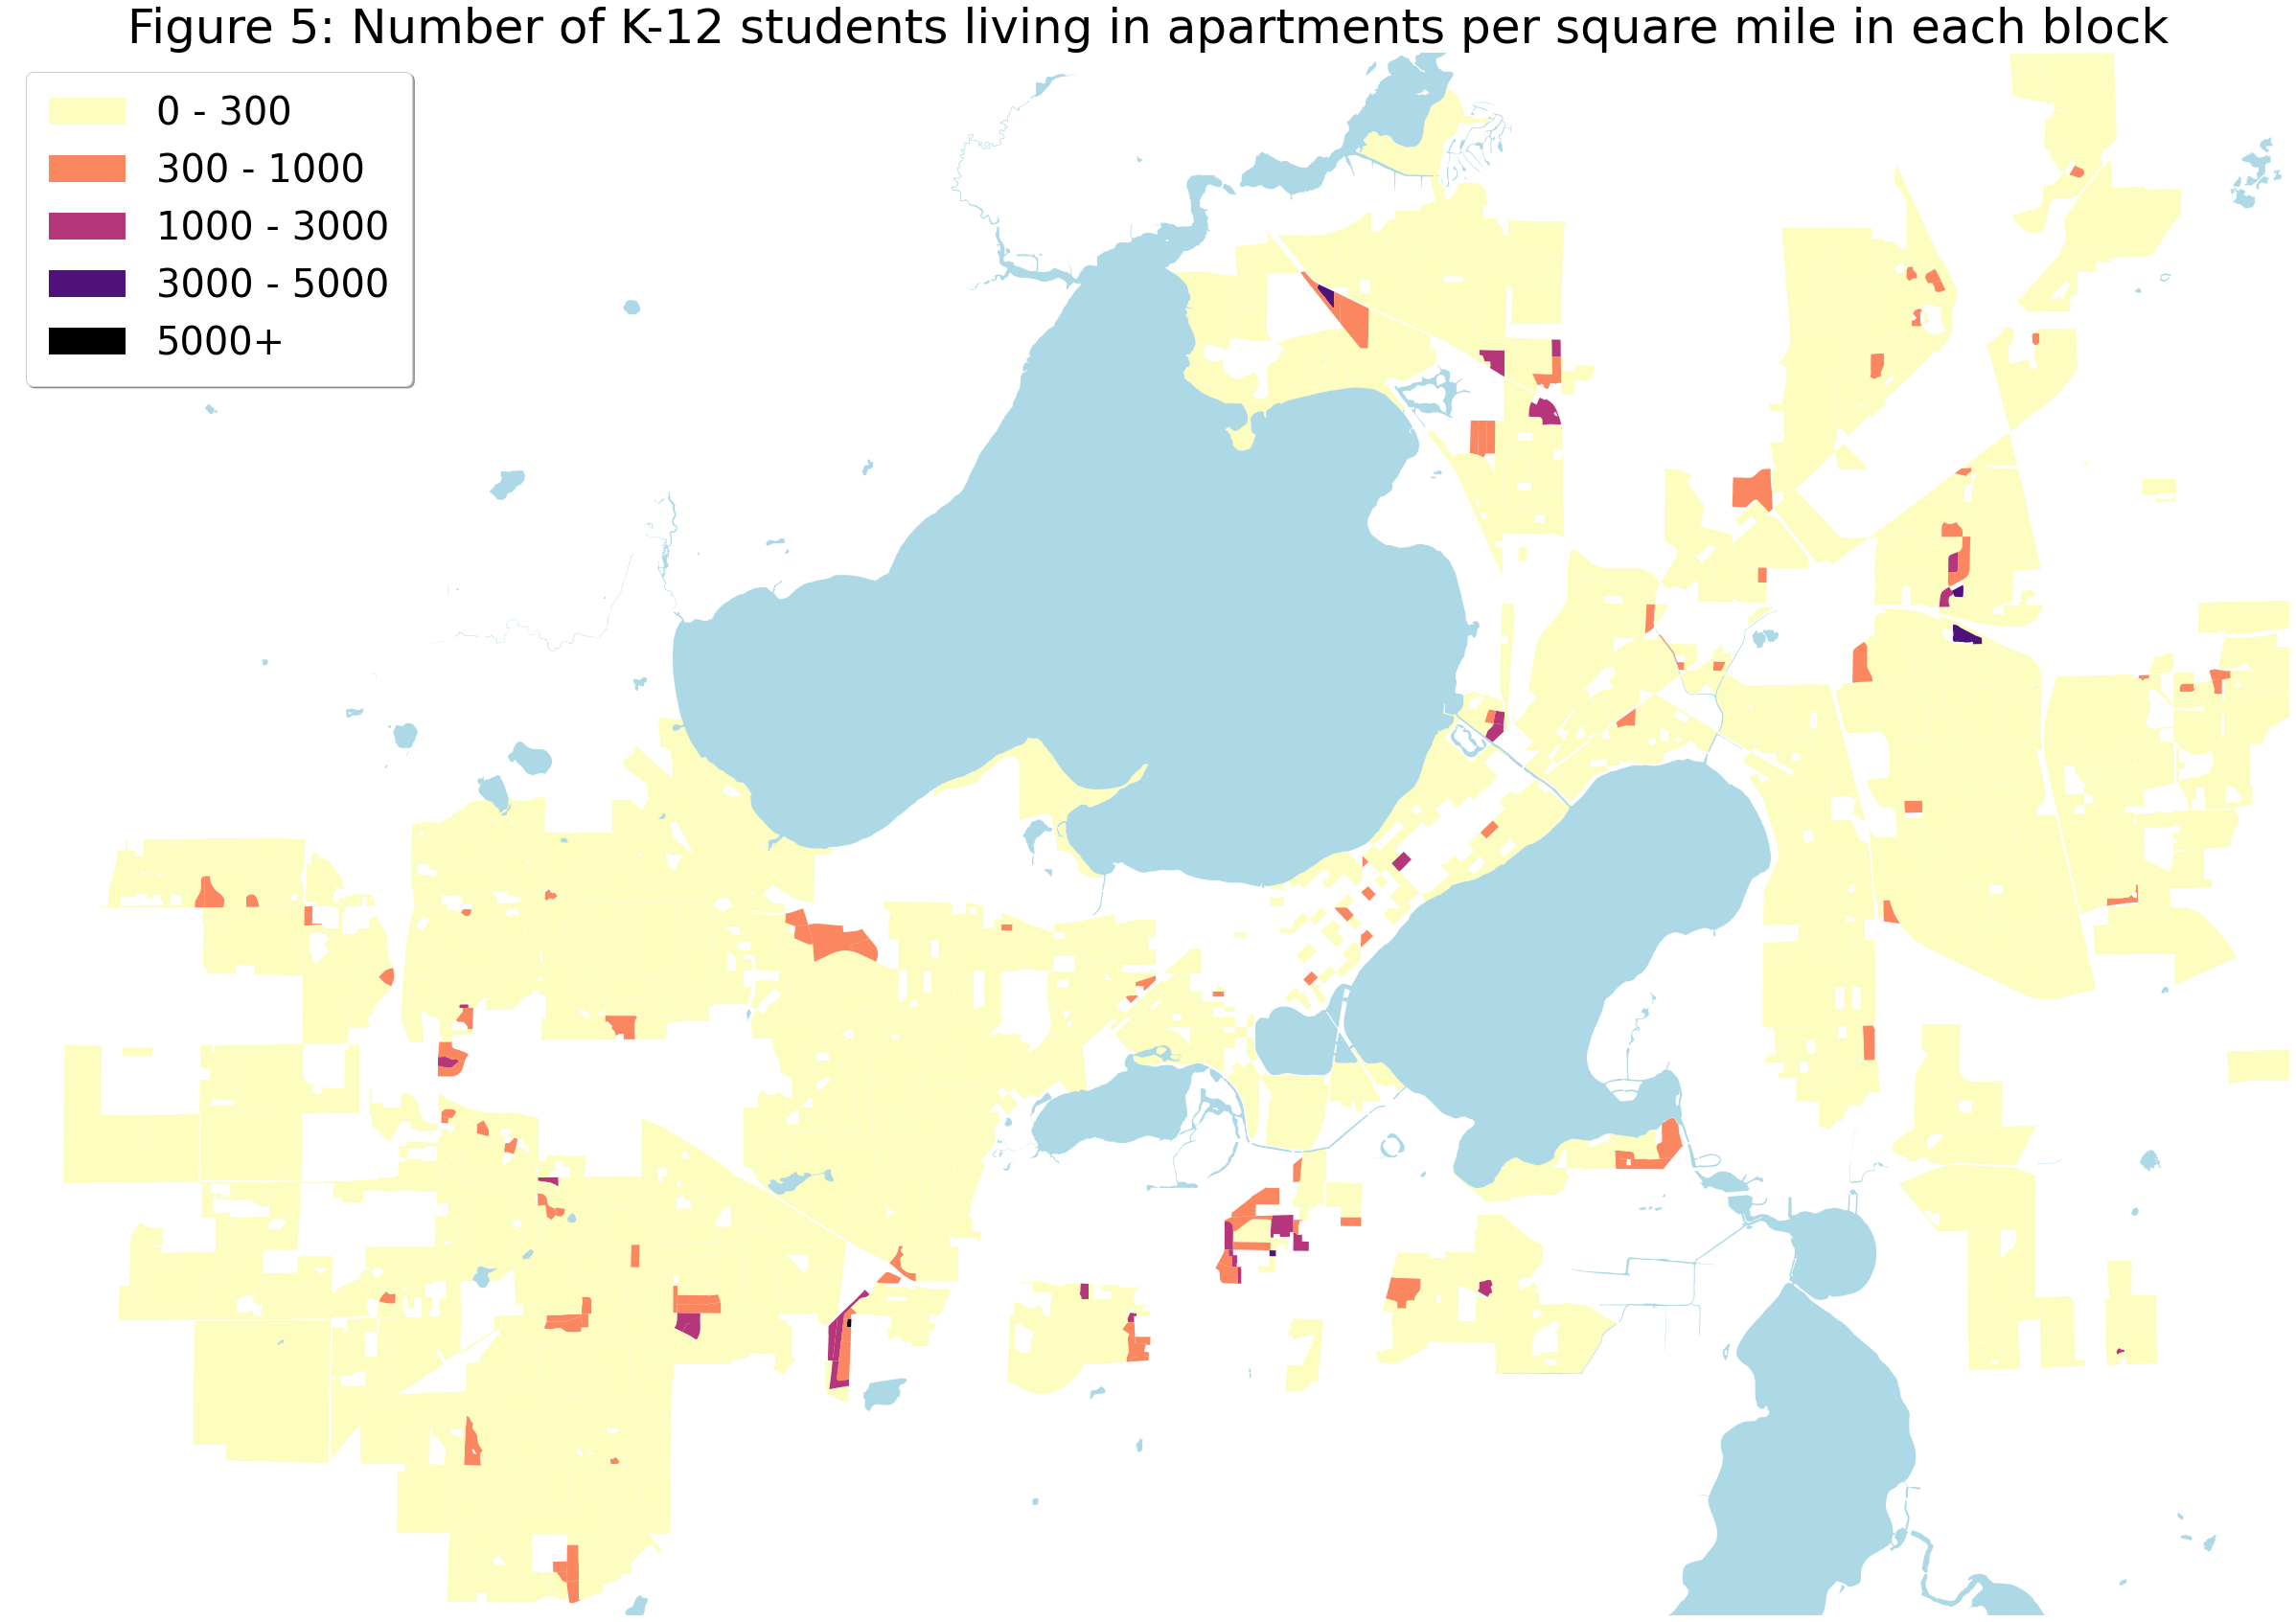

In [107]:
result = gpd.GeoDataFrame(result)
lake_df = lake_df.to_crs(result.crs)
apartment_madison = gpd.sjoin(result, dane, how="right", op="within")
apartment_madison = apartment_madison[["geometry", "apt_density"]]
apartment_madison = apartment_madison.dropna()

bp = mc.UserDefined(apartment_madison["apt_density"], bins=[300, 1000, 3000, 5000, 50000])
ax = apartment_madison.plot(figsize = (50, 30), legend=True, scheme = 'UserDefined',
                  classification_kwds={'bins': [300, 1000, 3000, 5000, 50000]}, k = 5, column='apt_density', cmap = 'magma_r')
handles, labels = ax.get_legend_handles_labels()
cmap = plt.get_cmap('magma_r')

bins = bp.bins
bins = np.insert(bins, 0, 0)
bp
LegendElement = [mpatches.Patch(facecolor=cmap(_*0.25), label=f'{int(max(bins[_], 0))} - {int(bins[_+1])}')
                 for _ in range(4)] + [mpatches.Patch(facecolor='black', hatch='', label='5000+')]

ax.legend(handles = LegendElement, loc='upper left', fontsize=40, shadow=True, borderpad=0.6)
lake_df.plot(ax=ax,color="lightblue")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim([43.000, 43.165])
ax.set_xlim([-89.58, -89.25])
ax.axis('off')
ax.set_title("Figure 5: Number of K-12 students living in apartments per square mile in each block", fontsize = 50)

### The density plot of k12 in other house

Text(0.5, 1.0, 'Figure 4: Number of K-12 students living in non-apartments per square mile in each block')

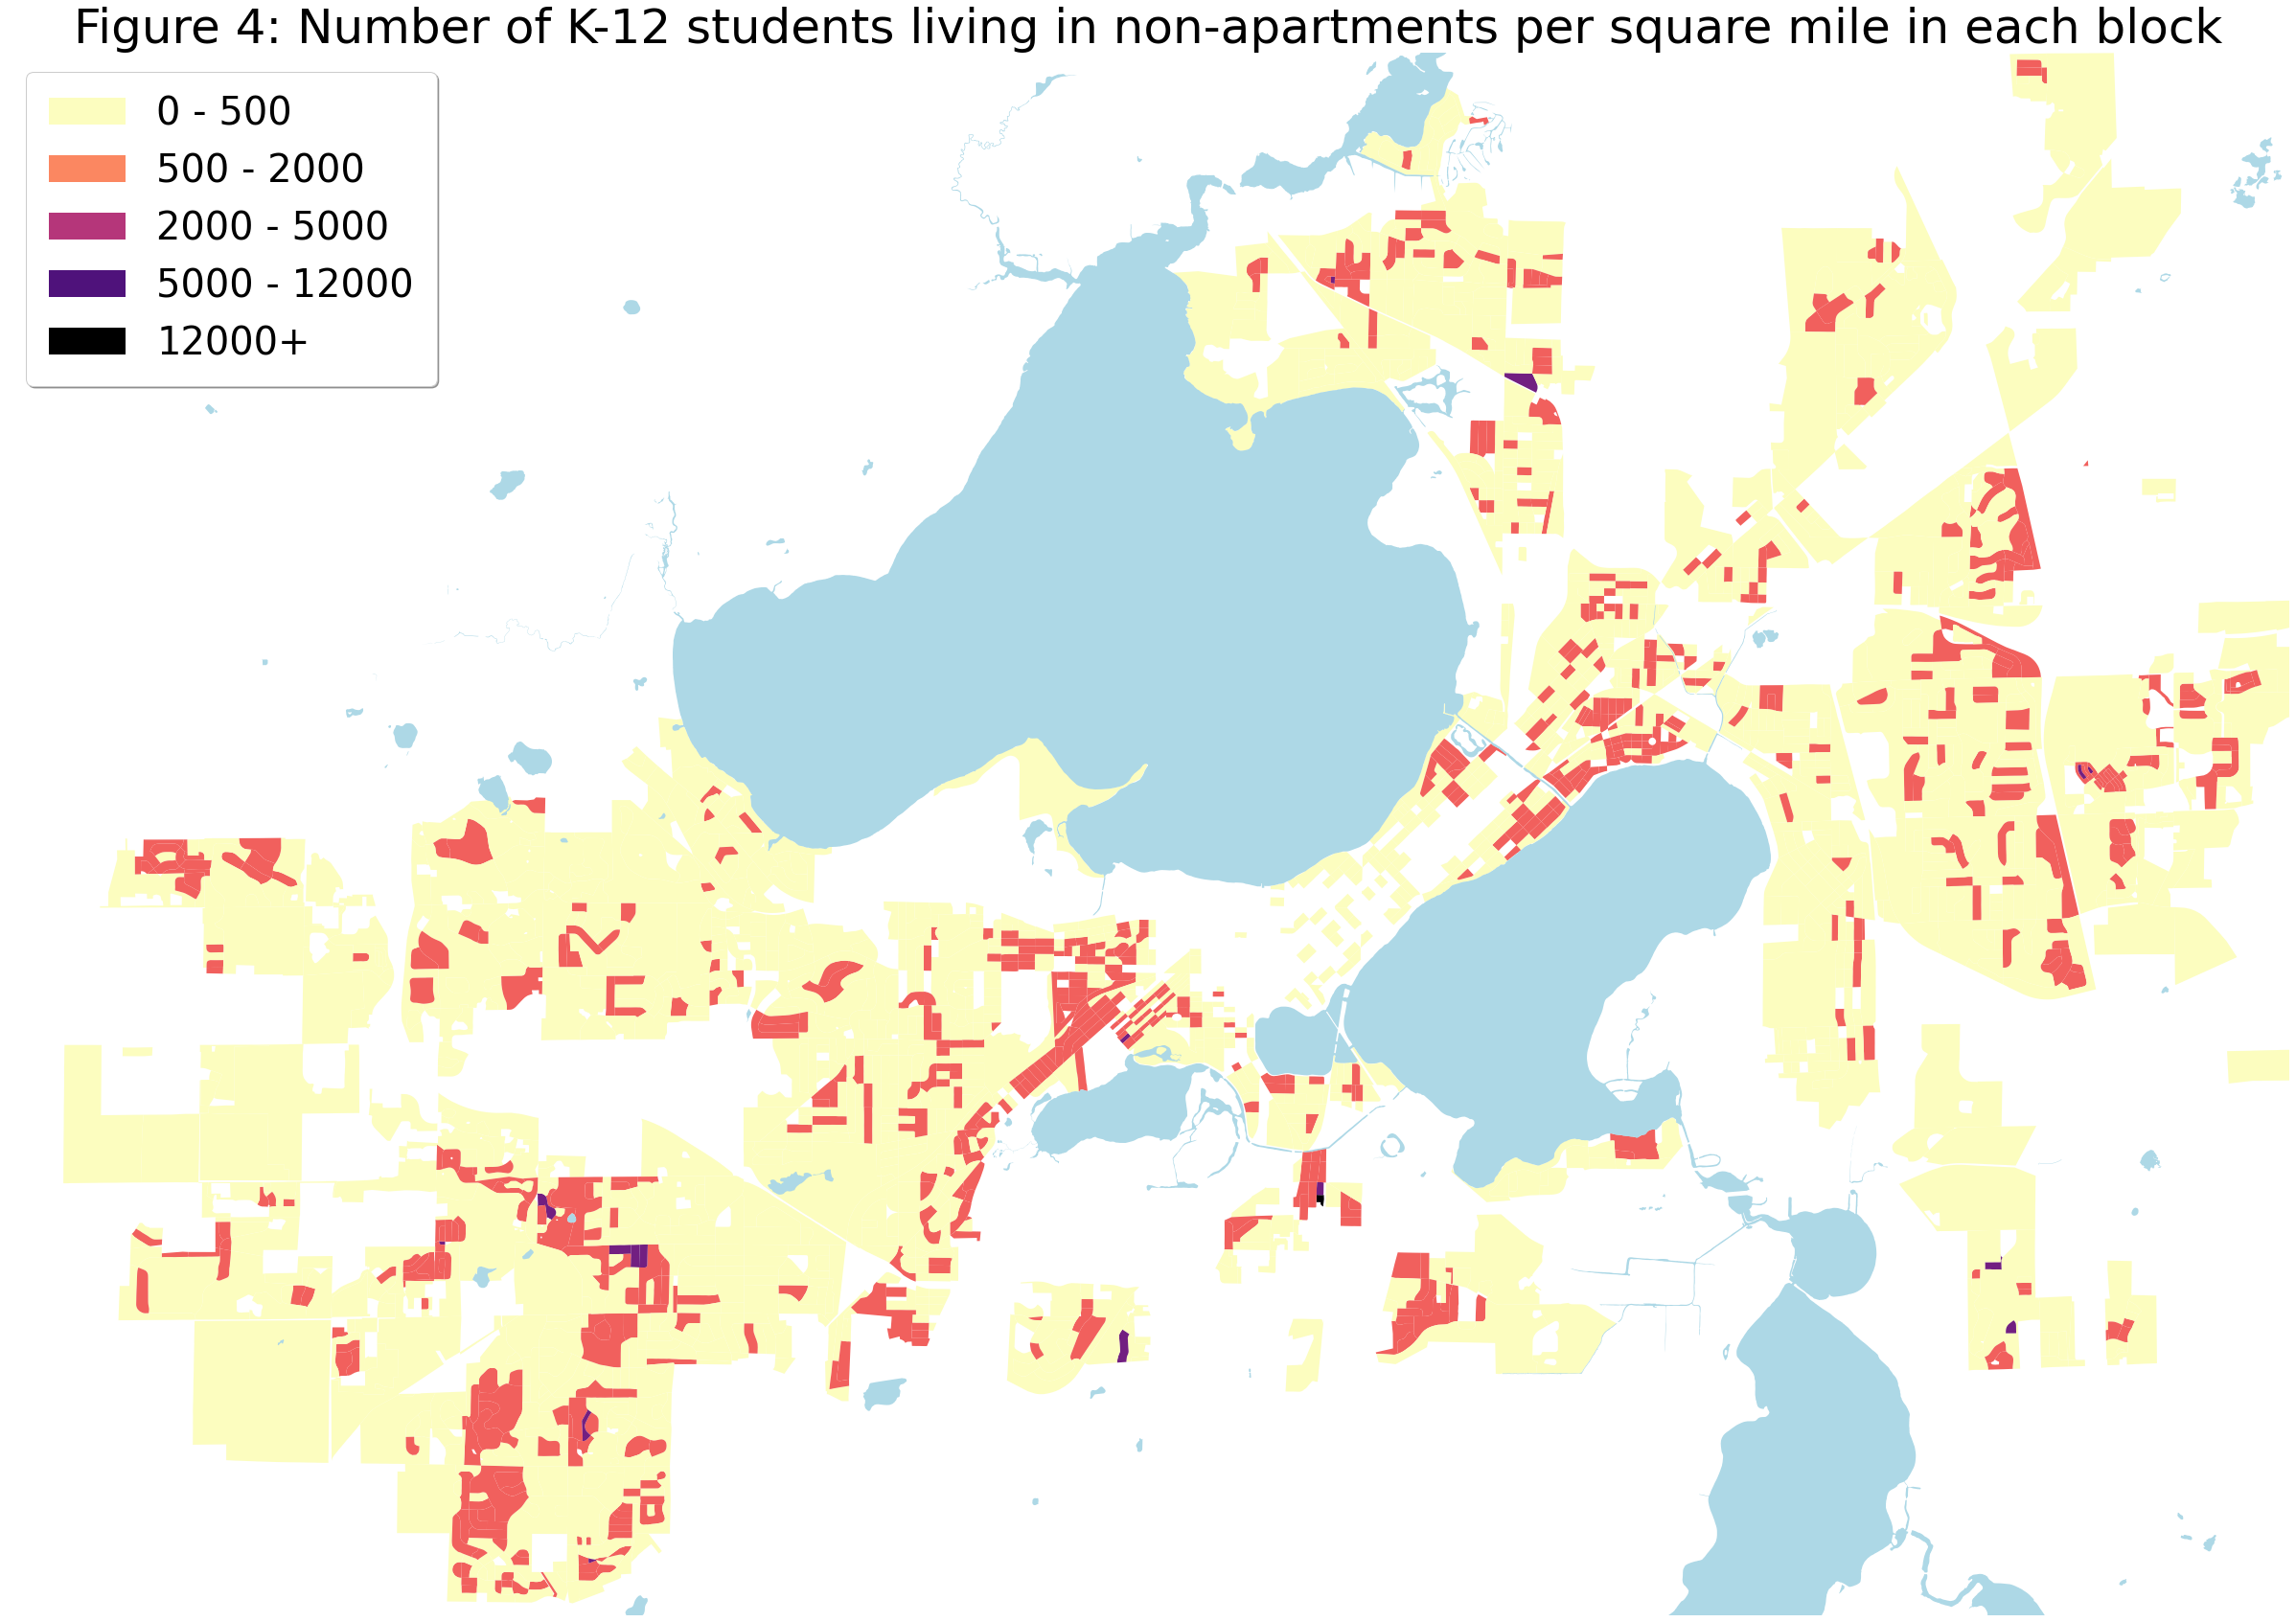

In [108]:
result = gpd.GeoDataFrame(result)
house_madison = gpd.sjoin(result, dane, how="right", op="within")
house_madison = house_madison[["geometry", "other_density"]]
house_madison = house_madison.dropna()
bp = mc.UserDefined(apartment_madison["apt_density"], bins=[500, 2000, 5000, 12000, 50000])
ax = house_madison.plot(figsize = (50, 30), legend=True, scheme = 'UserDefined',
                  classification_kwds={'bins': [500, 2000, 5000, 12000, 50000]}, k = 5, column='other_density', cmap = 'magma_r')
handles, labels = ax.get_legend_handles_labels()
cmap = plt.get_cmap('magma_r')
bins = bp.bins
bins = np.insert(bins, 0, 0)
LegendElement = [mpatches.Patch(facecolor=cmap(_*0.25), label=f'{int(max(bins[_], 0))} - {int(bins[_+1])}')
                 for _ in range(4)] + [mpatches.Patch(facecolor='black', hatch='', label='12000+')]
ax.legend(handles = LegendElement, loc='upper left', fontsize=40, shadow=True, borderpad=0.6)
lake_df.plot(ax=ax,color="lightblue")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim([43.000, 43.165])
ax.set_xlim([-89.58, -89.25])
ax.axis('off')
ax.set_title("Figure 4: Number of K-12 students living in non-apartments per square mile in each block", fontsize = 50)

## The density plot of k12 in each blocks

Text(0.5, 1.0, 'Figure 2: Number of K-12 students in Madison per census block per square mile')

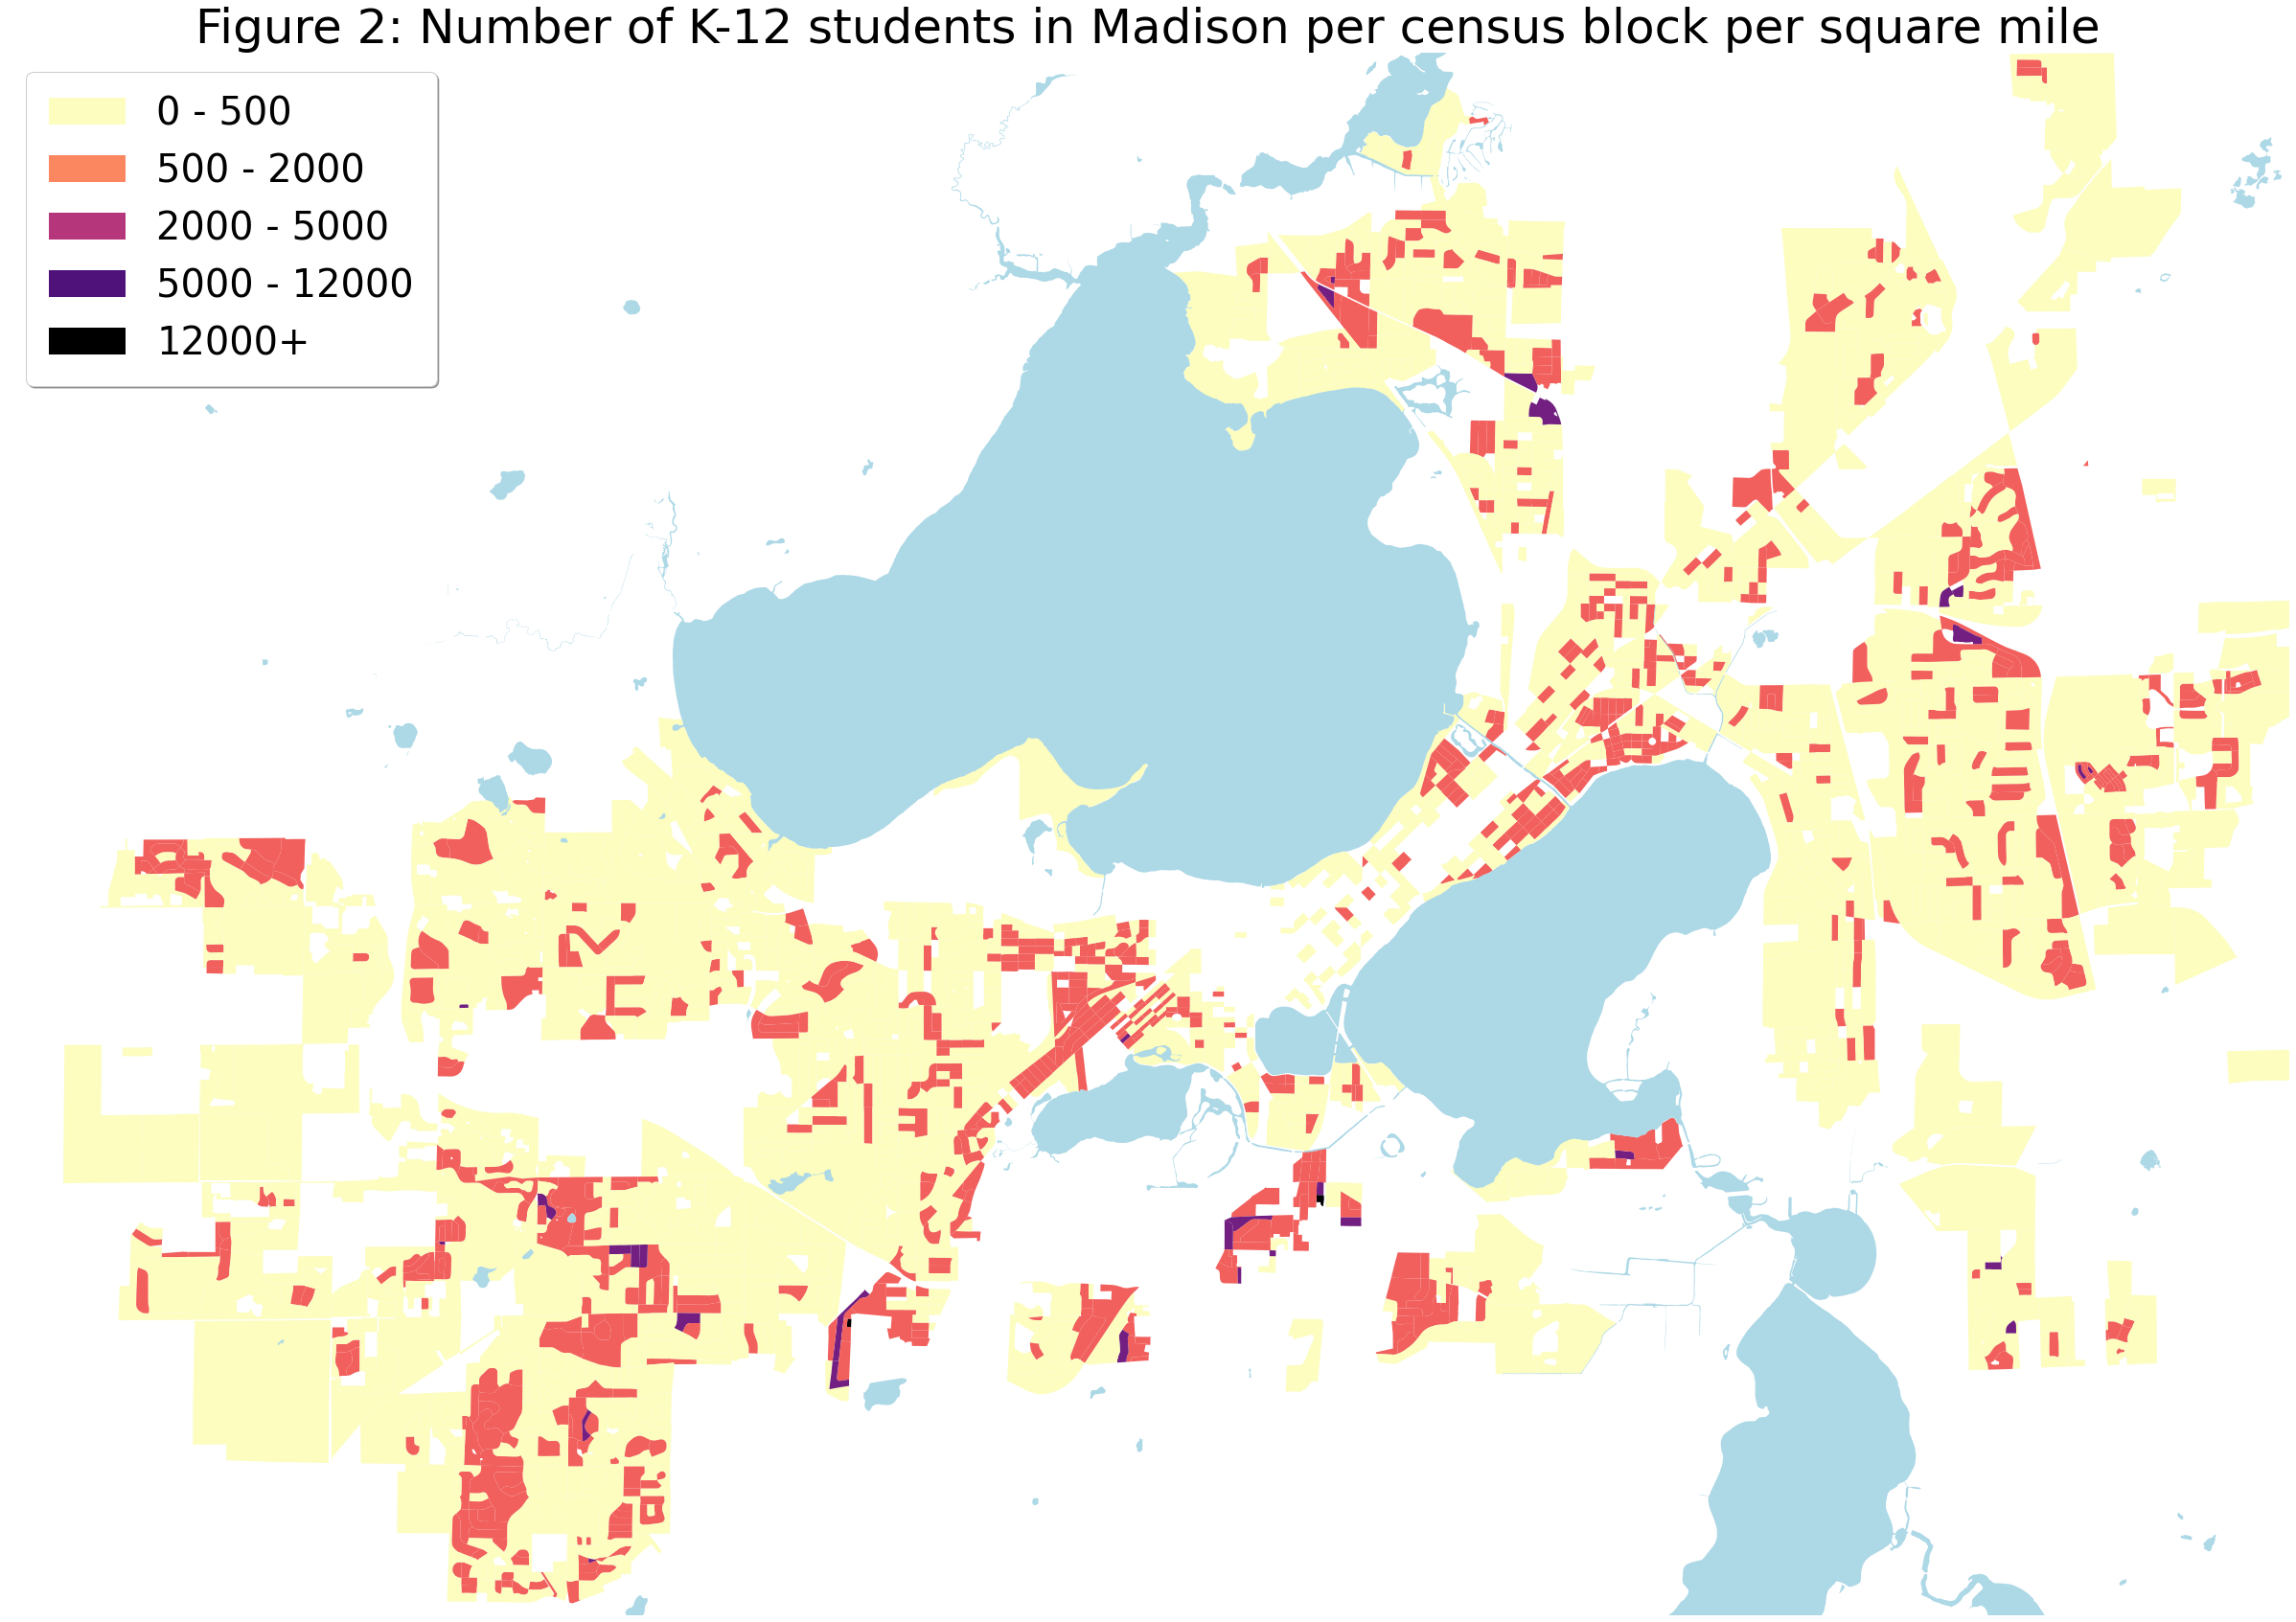

In [109]:
result["block_density"] = result['Total_K-12_block'] / result['area']
result = gpd.GeoDataFrame(result)
madison = gpd.sjoin(result, dane, how="right", op="within")
madison = madison[["geometry", "block_density"]]
madison = madison.dropna()
bp = mc.UserDefined(apartment_madison["apt_density"], bins=[500, 2000, 5000, 12000, 50000])
ax = madison.plot(figsize = (50, 30), legend=True, scheme = 'UserDefined',
                  classification_kwds={'bins': [500, 2000, 5000, 12000, 50000]}, k = 5, column='block_density', cmap = 'magma_r')
handles, labels = ax.get_legend_handles_labels()
cmap = plt.get_cmap('magma_r')
bins = bp.bins
bins = np.insert(bins, 0, 0)
LegendElement = [mpatches.Patch(facecolor=cmap(_*0.25), label=f'{int(max(bins[_], 0))} - {int(bins[_+1])}')
                 for _ in range(4)] + [mpatches.Patch(facecolor='black', hatch='', label='12000+')]
ax.legend(handles = LegendElement, loc='upper left', fontsize=40, shadow=True, borderpad=0.6)
lake_df.plot(ax=ax,color="lightblue")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim([43.000, 43.165])
ax.set_xlim([-89.58, -89.25])
ax.axis('off')
ax.set_title("Figure 2: Number of K-12 students in Madison per census block per square mile", fontsize = 50)

In [27]:
data = pd.read_csv("Top70_Apartments_final.csv")
data["#Bedrooms"] = data["#Bedrooms"].astype(int)
data["#K12Estimates"] = data["#K12Estimates"].astype(int)
data

FileNotFoundError: [Errno 2] File Top70_Apartments_final.csv does not exist: 'Top70_Apartments_final.csv'

In [ ]:
# data = data[["Address", "geometry", "Estimateed K-12 students"]]

In [ ]:
data["Est children per bedroom"] = data["#K12Estimates"] / data["#Bedrooms"]

In [ ]:
# html format
# data.to_csv("Final_result.csv",  index = False)